# Noise-aware Optimisation of Galton Circuits
**Purpose:** Compare noiseless vs noisy simulations, build simple NISQ noise models, apply transpiler optimizations, and report metrics (TV, KL, fidelity) and resource counts (gate count, depth).

## Objectives
1. Define a realistic noise model (1q error, 2q error, T1/T2, readout error) — a simple parameterized model we can tune.
2. Simulate baseline (noiseless) and noisy execution for representative k (e.g., k=4,8).
3. Use Qiskit's `transpile` (different optimization levels) to produce optimized circuits.
4. Evaluate metrics (TV, KL, fidelity) and circuit resource counters (depth, size).
5. Summarize best-performing transpile level and suggested mitigation strategies.

## Environment and noise model builder
- Import qiskit-aer noise utilities or build a simple dictionary-based noise representation.
- Provide a helper `build_noise_model(gate_error_1q, gate_error_2q, T1, T2, readout_error)` to create a noise model usable by AerSimulator.
- Document how to pick reasonable NISQ parameters (cite IBM device specs or typical values).

In [1]:
#Cell 1 : Installation
# Core Qiskit Terra + Aer
!pip install qiskit==1.3
!pip install qiskit-aer==0.15
!pip install qiskit-ibm-runtime==0.34.0

# Utilities
!pip install matplotlib numpy
!pip install pylatexenc==2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 

## Baseline (noiseless) runs
- Run the full circuit on `AerSimulator` without noise to obtain the ideal distribution.
- Save baseline metrics and histograms for later comparison.

In [2]:
from core_galton import GaltonEngine
from noise_optimisation import counts_to_prob_vector, build_noise_model, simulate_qc, compare_metrics
# Build k-layer circuit (example k=8)
k = 4
eng = GaltonEngine(layers=k, mode='full')
qc = eng.qc  # or eng.build_galton_circuit(); ensure circuit built
shots = 5000
seed = 42
noiseless_counts = simulate_qc(qc, shots=shots, seed=seed, noise_model=None)
# Convert to prob vector
target = counts_to_prob_vector(noiseless_counts, n_bins=k+1)

In [3]:
nm = build_noise_model(gate_error_1q=0.001,
                       gate_error_2q=0.01,
                       readout_error=0.02,
                       t1=50e-6, t2=70e-6)

## Noisy simulation
- Run the same circuits under the noise model (simulator with `noise_model`).
- Compute TV distance, KL divergence, and fidelity between noisy output and the ideal target distribution.
- Store metrics and print a small table.

In [4]:
noisy_counts = simulate_qc(qc, shots=shots, seed=seed+1, noise_model=nm)
metrics = compare_metrics(noisy_counts, target * shots, n_bins=k+1)  # pass expected counts or prob*shots
print(metrics)

{'tv': 0.38136511375947996, 'kl': 9.759797630772578, 'fidelity': 0.7850669488673083}


## Transpiler optimisation comparison
- For each transpiler optimization level (0..3), transpile the circuit and run it with the noise model.
- Record gate counts and depths, rerun metrics, and identify which level yields the best tradeoff.
- Optional: run a small search over basis gates or layout strategies if time permits.

In [5]:
from noise_optimisation import optimize_circuit
for level in [0,1,2,3]:
    opt_qc = optimize_circuit(qc, optimization_level=level)
    c = simulate_qc(opt_qc, shots=shots, seed=seed+2, noise_model=nm)
    m = compare_metrics(c, target * shots, n_bins=k+1)
    print("level", level, m)

level 0 {'tv': 0.3676900584795322, 'kl': 9.38628995273053, 'fidelity': 0.7941510140949475}
level 1 {'tv': 0.3676900584795322, 'kl': 9.38628995273053, 'fidelity': 0.7941510140949475}
level 2 {'tv': 0.3676900584795322, 'kl': 9.38628995273053, 'fidelity': 0.7941510140949475}
level 3 {'tv': 0.3676900584795322, 'kl': 9.38628995273053, 'fidelity': 0.7941510140949475}


## Interpretation
- Plot metrics vs optimization level (small table).
- Plot before/after histograms for the best optimization level.
- Interpret results: did optimization improve fidelity/TV? Which resources (2q gates / depth) changed most?

In [6]:
from binary_galton import run_binary_galton
from noise_optimisation import build_noise_model, compare_metrics
from math import comb
import numpy as np

k = 8
shots = 5000

# 1) run noiseless binary circuit (counts as int->count)
counts_noiseless = run_binary_galton(k, shots=shots, seed=42, noise_model=None)

# 2) analytic expected counts (list)
expected_counts = [comb(k, i) * (0.5 ** k) * shots for i in range(k + 1)]

# 3) compute prob vectors and metrics
from noise_optimisation import counts_to_prob_vector
p = counts_to_prob_vector(counts_noiseless, n_bins=k+1)
q = np.array(expected_counts) / sum(expected_counts)

print("Noiseless p sum:", p.sum(), "q sum:", q.sum())
from noise_optimisation import tv_distance, kl_divergence, bhattacharyya
print("Noiseless -> TV:", tv_distance(p, q), "KL:", kl_divergence(p, q), "Fid:", bhattacharyya(p, q))

# 4) run with noise model
nm = build_noise_model(gate_error_1q=0.001, gate_error_2q=0.01, readout_error=0.02)
counts_noisy = run_binary_galton(k, shots=shots, seed=43, noise_model=nm)
metrics = compare_metrics(counts_noisy, expected_counts, n_bins=k+1)
print("Noisy metrics:", metrics)

Noiseless p sum: 1.0 q sum: 1.0
Noiseless -> TV: 0.7702125 KL: 3.4806023138471955 Fid: 0.404342766284804
Noisy metrics: {'tv': 0.6240875, 'kl': 2.527019142489439, 'fidelity': 0.6531478727082072}



=== Circuit for k = 1 ===


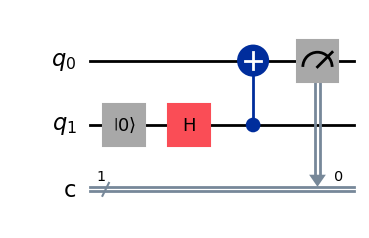


=== Circuit for k = 2 ===


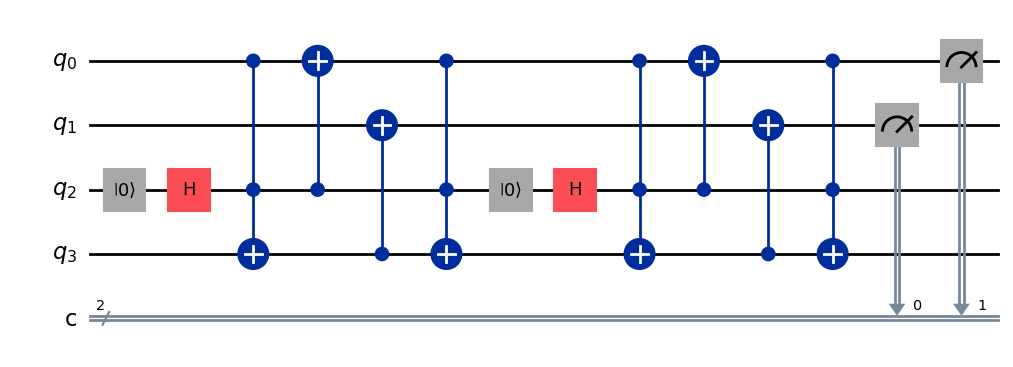


=== Circuit for k = 4 ===


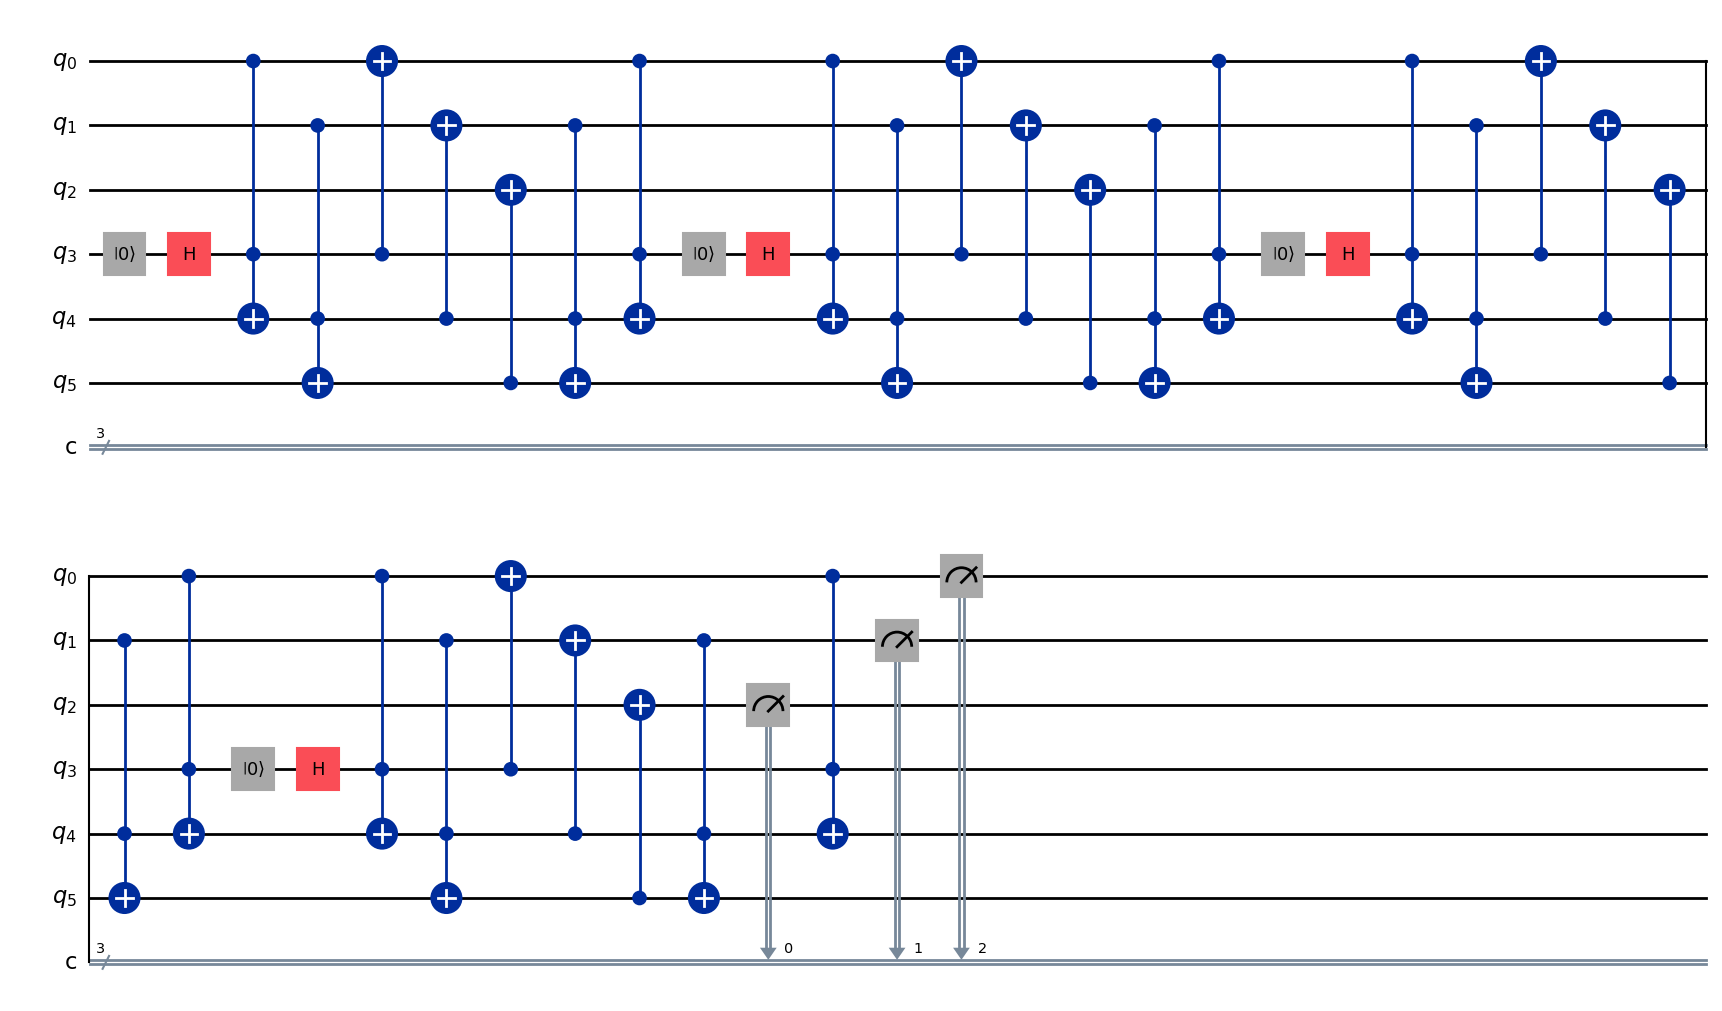


=== Circuit for k = 8 ===


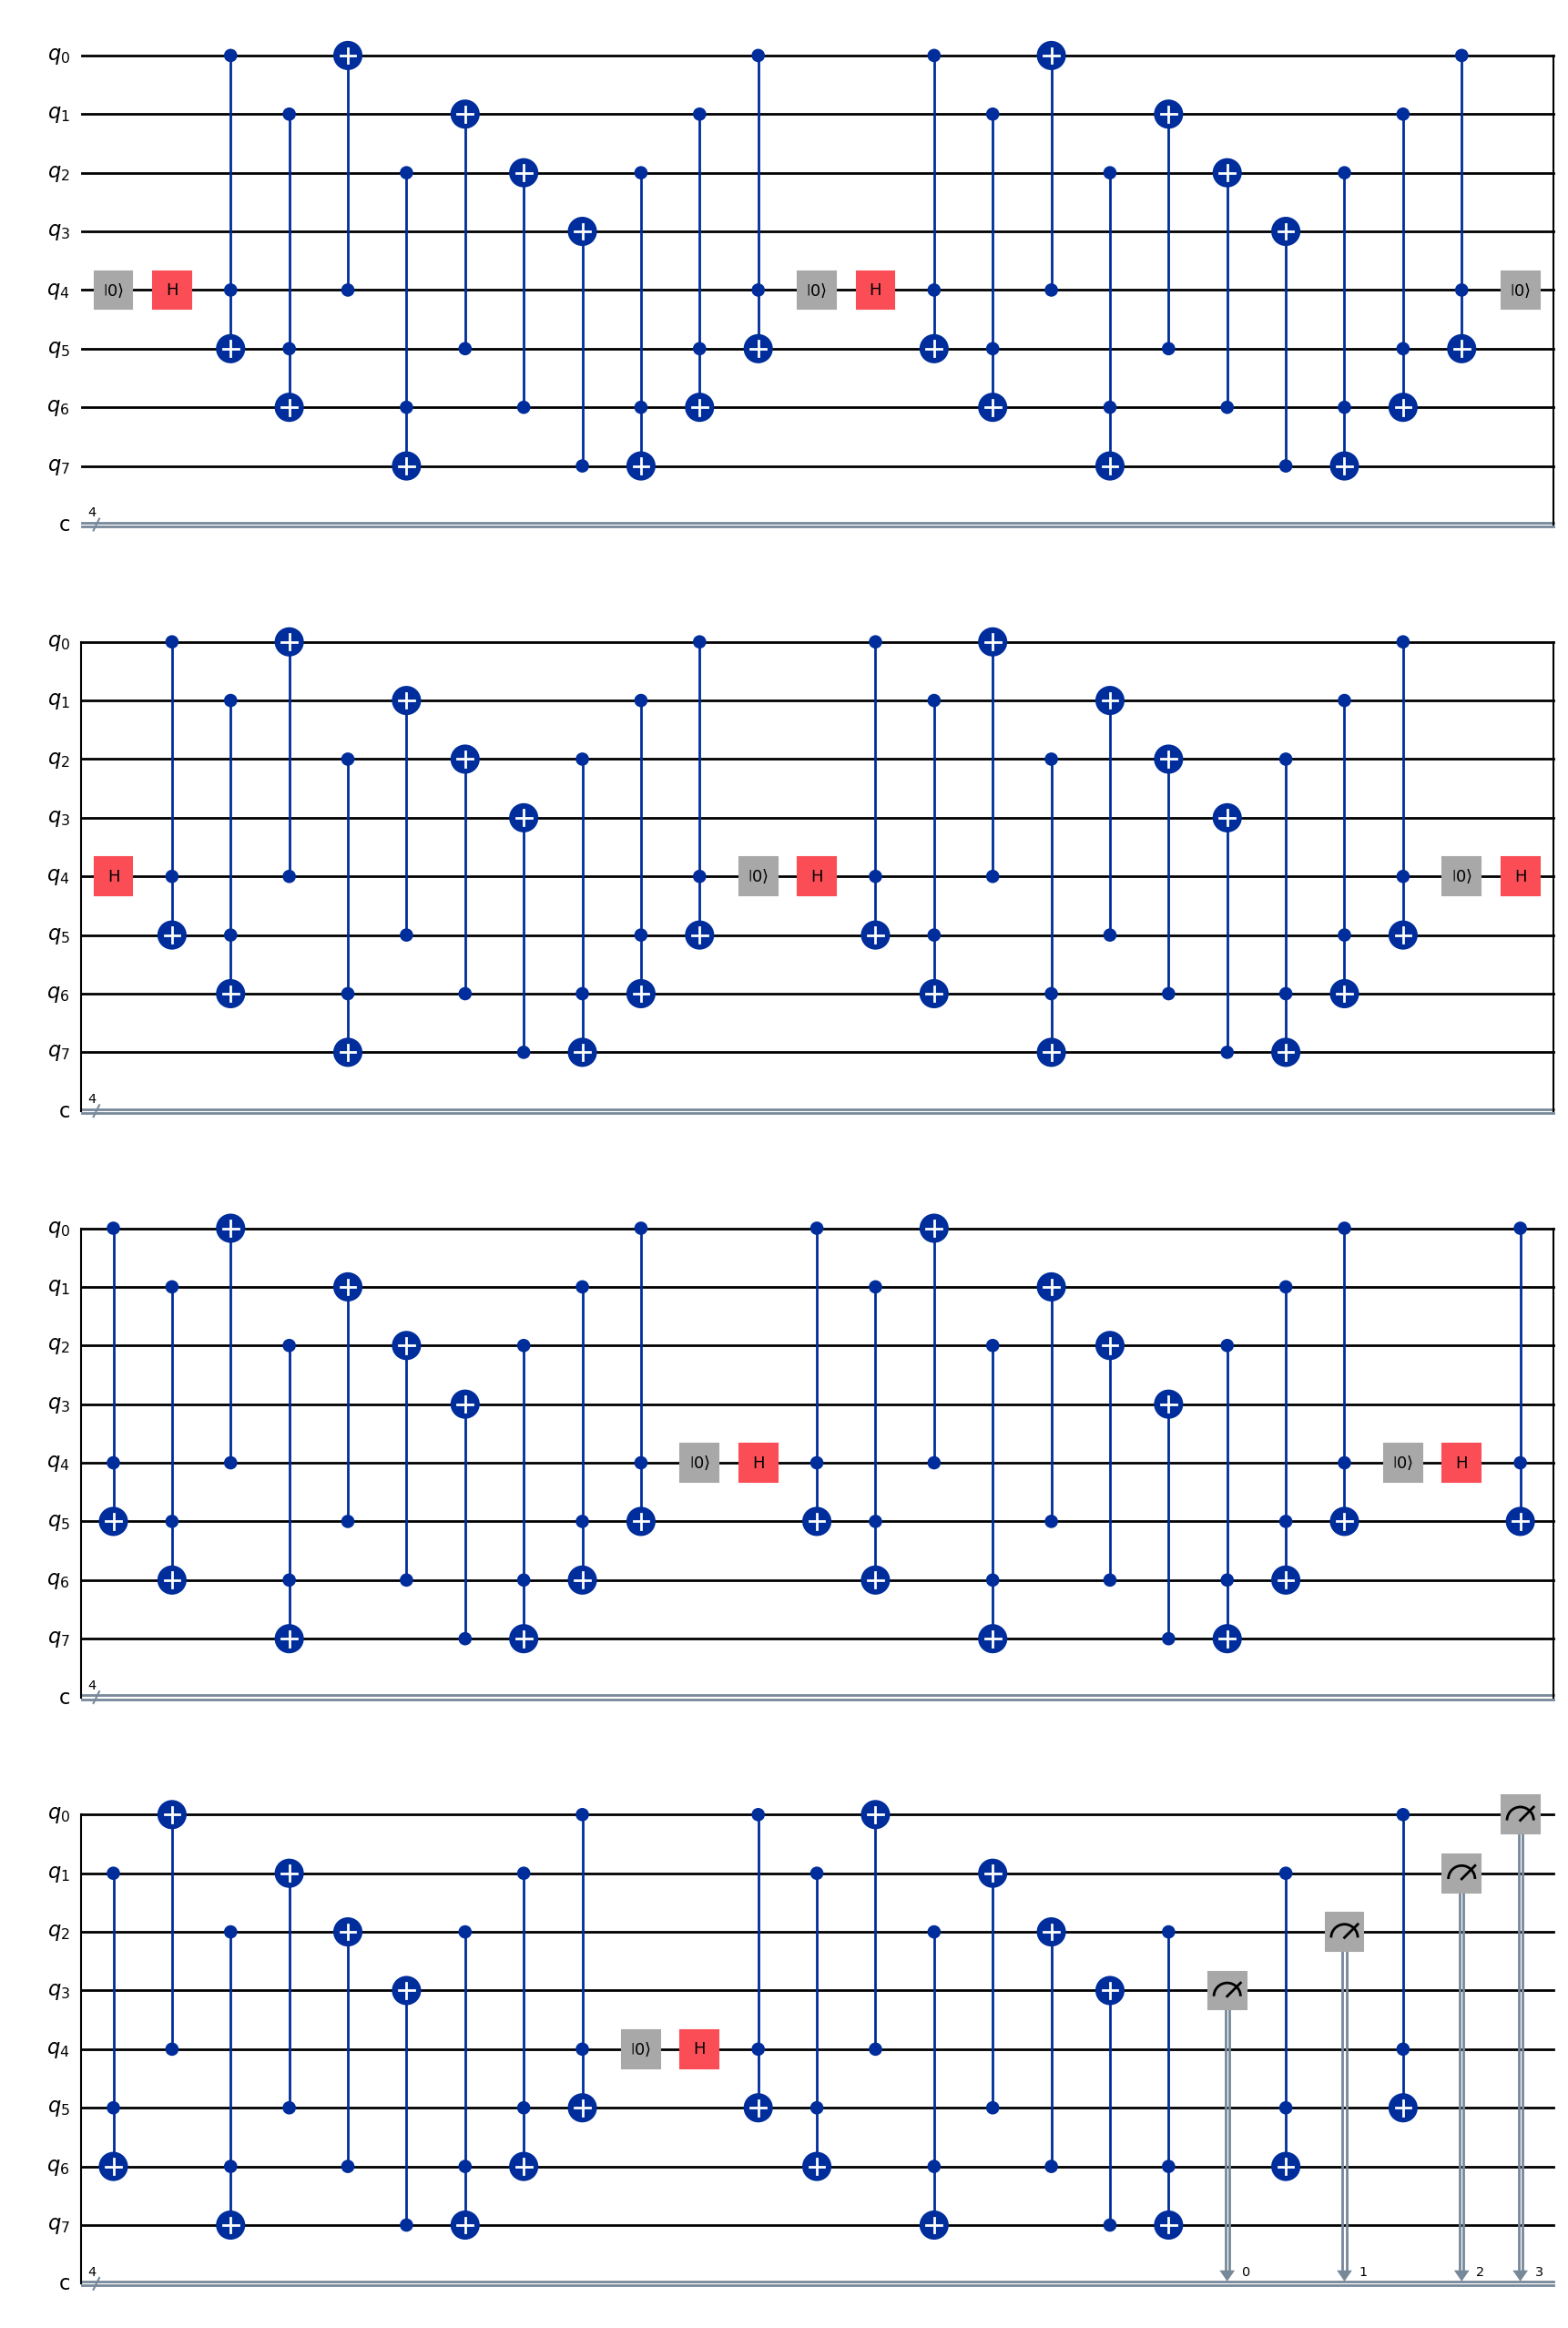


=== Circuit for k = 16 ===


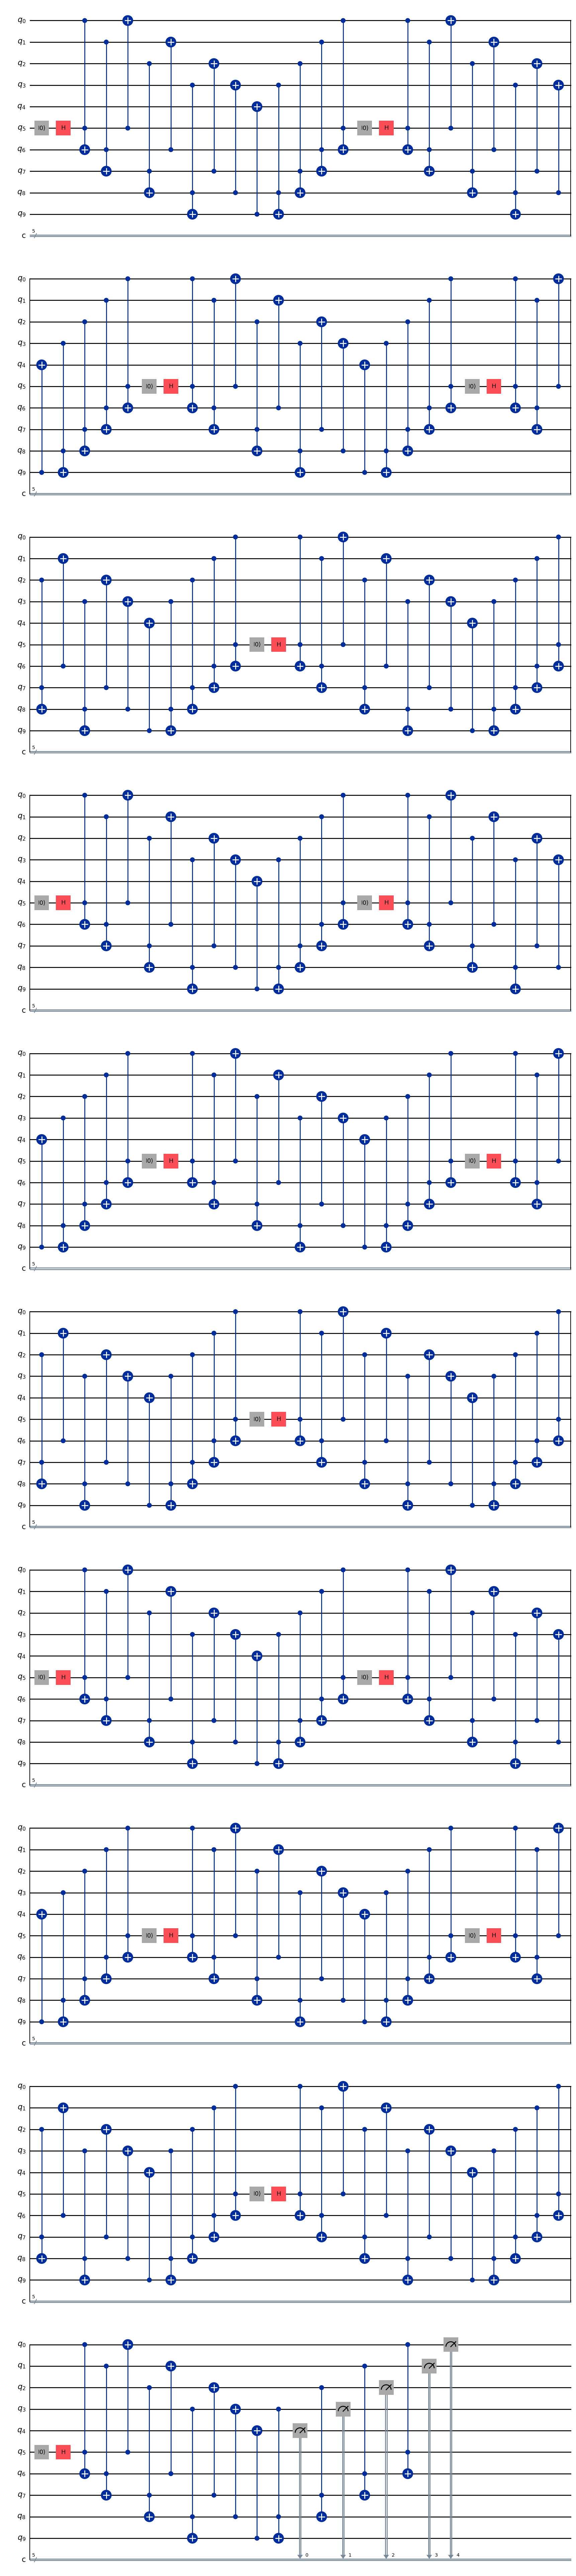


=== raw counts for k=1 (as returned by run_binary_galton) ===
{0: 977, 1: 1023}
TV if bitstring->int(MSB..LSB) : 0.0115
TV if bitstring->int(reversed)  : 0.0115
Counts interpreted as idx(MSB..LSB): {0: 977, 1: 1023}
Counts interpreted as idx(reversed): {0: 977, 1: 1023}

=== raw counts for k=2 (as returned by run_binary_galton) ===
{0: 964, 1: 0, 2: 1036}
TV if bitstring->int(MSB..LSB) : 0.5000
TV if bitstring->int(reversed)  : 0.5000
Counts interpreted as idx(MSB..LSB): {0: 964, 1: 0, 2: 1036}
Counts interpreted as idx(reversed): {0: 964, 1: 0, 2: 1036}

=== raw counts for k=4 (as returned by run_binary_galton) ===
{0: 761, 1: 0, 2: 123, 3: 120, 4: 996}
TV if bitstring->int(MSB..LSB) : 0.7535
TV if bitstring->int(reversed)  : 0.7535
Counts interpreted as idx(MSB..LSB): {0: 761, 1: 0, 2: 123, 3: 120, 4: 996}
Counts interpreted as idx(reversed): {0: 761, 1: 0, 2: 123, 3: 120, 4: 996}


In [7]:
# Diagnostic cell
from binary_galton import build_binary_galton_circuit, run_binary_galton
from noise_optimisation import counts_to_prob_vector, tv_distance
from math import comb
import numpy as np
import pprint

pp = pprint.PrettyPrinter(indent=2)

def analytic_counts(k, shots):
    return [comb(k, i) * (0.5**k) * shots for i in range(k+1)]

def try_orders_and_tv(raw_counts, k, shots):
    # raw_counts may be dict(int->count) or bitstring->count
    # Produce two interpretations:
    #  - idx_A = int(bitstring, 2)    # MSB..LSB interpretation
    #  - idx_B = int(bitstring[::-1], 2) # reversed interpretation
    counts_A = {i:0 for i in range(k+1)}
    counts_B = {i:0 for i in range(k+1)}
    if all(isinstance(k_, (int, np.integer)) for k_ in raw_counts.keys()):
        # already int->counts
        for i,c in raw_counts.items():
            if 0 <= int(i) <= k:
                counts_A[int(i)] += c
                counts_B[int(i)] += c
    else:
        for bs, c in raw_counts.items():
            s = str(bs).replace(' ', '')
            try:
                idxA = int(s, 2)
                idxB = int(s[::-1], 2)
            except:
                continue
            if 0 <= idxA <= k: counts_A[idxA] += c
            if 0 <= idxB <= k: counts_B[idxB] += c

    # convert to probability vectors
    pA = np.array([counts_A[i] for i in range(k+1)], dtype=float)
    pB = np.array([counts_B[i] for i in range(k+1)], dtype=float)
    if pA.sum()>0: pA /= pA.sum()
    if pB.sum()>0: pB /= pB.sum()
    exp = np.array(analytic_counts(k, shots), dtype=float)
    exp = exp / exp.sum()
    tvA = tv_distance(pA, exp)
    tvB = tv_distance(pB, exp)
    return (counts_A, tvA), (counts_B, tvB)

# 1) Display circuits for very small k
for k in (1,2,4,8,16):
    qc = build_binary_galton_circuit(k)
    print("\n=== Circuit for k =", k, "===")
    display(qc.draw(output='mpl'))

# 2) Run small k tests (low shots for quick print)
for k in (1,2,4):
    shots = 2000
    raw = run_binary_galton(k, shots=shots, seed=123, noise_model=None)
    print(f"\n=== raw counts for k={k} (as returned by run_binary_galton) ===")
    pp.pprint(raw)
    (cA, tvA), (cB, tvB) = try_orders_and_tv(raw, k, shots)
    print(f"TV if bitstring->int(MSB..LSB) : {tvA:.4f}")
    print(f"TV if bitstring->int(reversed)  : {tvB:.4f}")
    print("Counts interpreted as idx(MSB..LSB):", cA)
    print("Counts interpreted as idx(reversed):", cB)

In [8]:
from binary_galton import build_binary_galton_circuit
qc = build_binary_galton_circuit(20)
print(qc)
# simulate with Aer and print raw counts (string keys)
from qiskit_aer import AerSimulator
from qiskit import transpile
sim = AerSimulator()
tqc = transpile(qc, sim)
res = sim.run(tqc, shots=2000, seed_simulator=123).result()
print(res.get_counts())

                         ┌───┐                                             »
q_0: ────────────■───────┤ X ├─────────────────────────────────────────────»
                 │       └─┬─┘     ┌───┐                                   »
q_1: ────────────┼────■────┼───────┤ X ├────────────────────────────────■──»
                 │    │    │       └─┬─┘     ┌───┐                      │  »
q_2: ────────────┼────┼────┼────■────┼───────┤ X ├─────────────────■────┼──»
                 │    │    │    │    │       └─┬─┘┌───┐            │    │  »
q_3: ────────────┼────┼────┼────┼────┼────■────┼──┤ X ├───────■────┼────┼──»
                 │    │    │    │    │    │    │  └─┬─┘┌───┐  │    │    │  »
q_4: ────────────┼────┼────┼────┼────┼────┼────┼────┼──┤ X ├──┼────┼────┼──»
          ┌───┐  │    │    │    │    │    │    │    │  └─┬─┘  │    │    │  »
q_5: ─|0>─┤ H ├──■────┼────■────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
          └───┘┌─┴─┐  │         │    │    │    │    │    │    │    │    │  »

In [9]:
from quick_parallel_galton import run_parallel_galton
from math import comb
import numpy as np
k = 8
shots = 5000
counts_par = run_parallel_galton(k, shots=shots, seed=42, noise_model=None)
expected = [comb(k,i)*(0.5**k)*shots for i in range(k+1)]
# compute TV or other metrics with your compare_metrics (it handles dicts)
from noise_optimisation import compare_metrics
metrics = compare_metrics(counts_par, expected, n_bins=k+1)
print("Parallel coins (noiseless) metrics:", metrics)

Parallel coins (noiseless) metrics: {'tv': 0.0163125, 'kl': 0.0009690331812208966, 'fidelity': 0.99975575151909}


## Visualisation & interpretation
- Plot metrics vs optimization level (bars or table).
- Plot before/after histograms for the best optimization level.
- Interpret results: did optimization improve fidelity/TV? Which resources (2q gates / depth) changed most?

Summary (level -> tv, kl, fidelity, cx, depth):
lvl 0 -> tv=0.3807, kl=0.3948, fid=0.8887, cx=144, depth=219
lvl 1 -> tv=0.3810, kl=0.3972, fid=0.8884, cx=144, depth=219
lvl 2 -> tv=0.3743, kl=0.3873, fid=0.8920, cx=112, depth=206
lvl 3 -> tv=0.3743, kl=0.3873, fid=0.8920, cx=112, depth=206


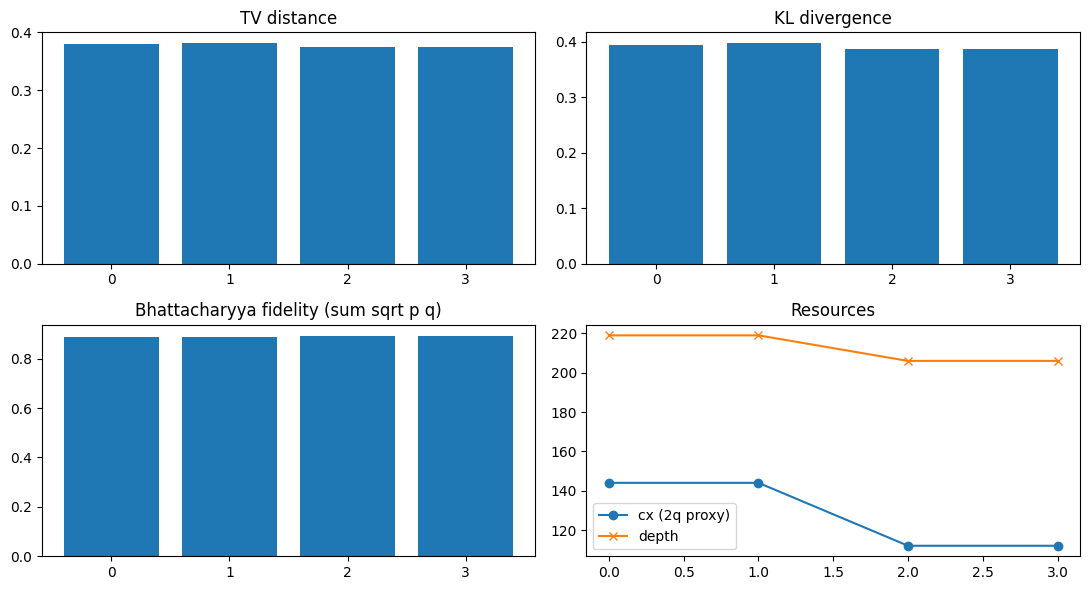

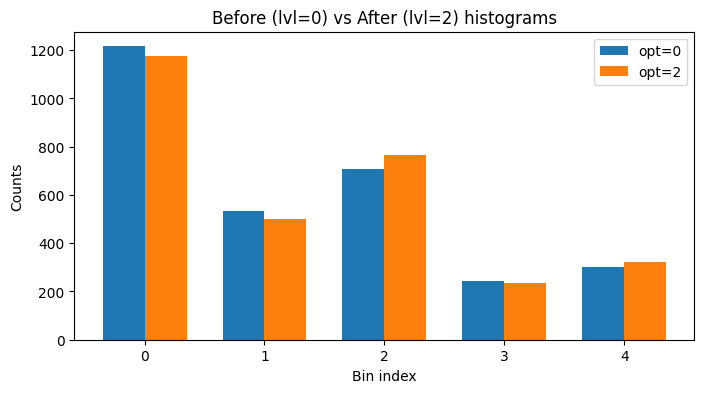

In [12]:
# ====== Noise-optimisation & plotting cell ======
import numpy as np
import matplotlib.pyplot as plt
from math import comb
from qiskit import QuantumCircuit, transpile
# Try different Aer imports depending on qiskit-aer version
try:
    from qiskit_aer import AerSimulator
    from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
except Exception:
    try:
        from qiskit_aer import AerSimulator
        from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
    except Exception as e:
        raise ImportError("AerSimulator / NoiseModel import failed — install qiskit-aer.") from e

# ----------------- Utility helpers -----------------
def analytic_binomial_probs(k: int):
    """Return analytic binomial probability vector for k layers (bins = 0..k)."""
    return np.array([comb(k, i) * (0.5 ** k) for i in range(k + 1)], dtype=float)

def counts_to_bin_counts(counts: dict, positions: int) -> dict:
    """
    Convert Qiskit measurement counts (strings) into bin counts 0..positions-1.
    Uses LSB-first scan as primary mapping (s[::-1].find('1')) for robustness.
    """
    bins = {i: 0 for i in range(positions)}
    for bs, c in counts.items():
        s = str(bs).replace(" ", "")  # strip spaces if any
        if '1' in s:
            # prefer LSB-first index
            lsb_index = s[::-1].find('1')
            if 0 <= lsb_index < positions:
                bins[lsb_index] += c
            else:
                # fallback mapping
                msb_index = s.find('1')
                idx = positions - 1 - msb_index
                if 0 <= idx < positions:
                    bins[idx] += c
                else:
                    # fallback: add to bin 0
                    bins[0] += c
        else:
            bins[0] += c
    return bins

# ----------------- Galton builder (simple, reliable) -----------------
def build_galton_circuit(k: int, mode: str = "full") -> QuantumCircuit:
    positions = k + 1
    if mode == "full":
        total_qubits = positions + 1
        qc = QuantumCircuit(total_qubits, positions)
        coin = positions
        center = positions // 2
        qc.x(center)
        for layer in range(k):
            qc.reset(coin)
            qc.h(coin)
            for i in range(positions - 1):
                mid = i
                right = i + 1
                qc.cswap(coin, mid, right)
                qc.cx(right, coin)
    else:
        qc = QuantumCircuit(positions, positions)
        for i in range(positions):
            qc.h(i)
    qc.measure(list(range(positions)), list(range(positions)))
    return qc

def simulate_circuit(qc: QuantumCircuit, shots: int = 3000, seed: int = None, noise_model=None):
    sim = AerSimulator(noise_model=noise_model) if noise_model is not None else AerSimulator()
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots, seed_simulator=seed)
    result = job.result()
    return result.get_counts()

# ----------------- Noise model builder (simple param version) -----------------
def build_simple_noise_model(gate_error_1q=0.001, gate_error_2q=0.01, readout_error=0.02):
    nm = NoiseModel()
    # Depolarizing errors for common gates (best-effort list)
    e1 = depolarizing_error(gate_error_1q, 1)
    e2 = depolarizing_error(gate_error_2q, 2)
    # Attach to common single- and two-qubit instructions
    nm.add_all_qubit_quantum_error(e1, ['u1','u2','u3','x','rx','ry','rz','sx'])
    nm.add_all_qubit_quantum_error(e2, ['cx','cz'])
    # readout error
    ro = ReadoutError([[1-readout_error, readout_error],[readout_error, 1-readout_error]])
    nm.add_all_qubit_readout_error(ro)
    return nm

# ----------------- Metrics -----------------
def compute_metrics_from_bin_counts(bin_counts: dict, k: int):
    p = analytic_binomial_probs(k)
    total = float(sum(bin_counts.values())) + 1e-12
    q = np.array([bin_counts.get(i, 0) for i in range(k+1)], dtype=float) / total
    tv = 0.5 * np.sum(np.abs(p - q))
    kl = float(np.sum(np.where(p > 0, p * np.log((p + 1e-12) / (q + 1e-12)), 0.0)))
    fidelity = float(np.sum(np.sqrt(p * q)))
    return {"p": p, "q": q, "tv": float(tv), "kl": float(kl), "fidelity": float(fidelity)}

# ----------------- Evaluation across transpiler levels -----------------
def evaluate_transpile_levels(qc, k, shots=3000, noise_model=None, seed=None, levels=(0,1,2,3)):
    sim = AerSimulator(noise_model=noise_model) if noise_model is not None else AerSimulator()
    results = {}
    for lvl in levels:
        tqc = transpile(qc, sim, optimization_level=lvl)
        depth = tqc.depth()
        ops = tqc.count_ops()
        cx_count = ops.get('cx', 0) + ops.get('ccx', 0)
        job = sim.run(tqc, shots=shots, seed_simulator=seed)
        res = job.result()
        raw = res.get_counts()
        bin_counts = counts_to_bin_counts(raw, positions=k+1)
        metrics = compute_metrics_from_bin_counts(bin_counts, k)
        metrics.update({"depth": depth, "cx": int(cx_count)})
        results[lvl] = metrics
    return results

# ----------------- Plotting helpers -----------------
def plot_metrics_vs_level(results: dict):
    levels = sorted(results.keys())
    tvs = [results[l]['tv'] for l in levels]
    kls = [results[l]['kl'] for l in levels]
    fids = [results[l]['fidelity'] for l in levels]
    cx = [results[l]['cx'] for l in levels]
    depth = [results[l]['depth'] for l in levels]

    x = np.arange(len(levels))
    fig, axes = plt.subplots(2,2, figsize=(11,6))
    axes[0,0].bar(x, tvs); axes[0,0].set_title("TV distance"); axes[0,0].set_xticks(x); axes[0,0].set_xticklabels(levels)
    axes[0,1].bar(x, kls); axes[0,1].set_title("KL divergence"); axes[0,1].set_xticks(x); axes[0,1].set_xticklabels(levels)
    axes[1,0].bar(x, fids); axes[1,0].set_title("Bhattacharyya fidelity (sum sqrt p q)"); axes[1,0].set_xticks(x); axes[1,0].set_xticklabels(levels)
    axes[1,1].plot(x, cx, marker='o', label='cx (2q proxy)'); axes[1,1].plot(x, depth, marker='x', label='depth'); axes[1,1].set_title("Resources"); axes[1,1].legend()
    plt.tight_layout()
    plt.show()

def plot_before_after_histograms(qc, best_level, k, shots=3000, noise_model=None, seed=None):
    sim = AerSimulator(noise_model=noise_model) if noise_model is not None else AerSimulator()
    tqc0 = transpile(qc, sim, optimization_level=0)
    res0 = sim.run(tqc0, shots=shots, seed_simulator=seed).result()
    tqcb = transpile(qc, sim, optimization_level=best_level)
    resb = sim.run(tqcb, shots=shots, seed_simulator=seed).result()
    bins0 = counts_to_bin_counts(res0.get_counts(), positions=k+1)
    binsb = counts_to_bin_counts(resb.get_counts(), positions=k+1)

    x = np.arange(k+1)
    w = 0.35
    plt.figure(figsize=(8,4))
    plt.bar(x - w/2, [bins0[i] for i in x], width=w, label='opt=0')
    plt.bar(x + w/2, [binsb[i] for i in x], width=w, label=f'opt={best_level}')
    plt.xticks(x)
    plt.xlabel("Bin index"); plt.ylabel("Counts")
    plt.title(f"Before (lvl=0) vs After (lvl={best_level}) histograms")
    plt.legend()
    plt.show()

# ----------------- Example run -----------------
if True:
    k = 4
    qc = build_galton_circuit(k, mode="full")
    # optional: create simple noise model (comment out if qiskit-aer noise API unavailable)
    try:
        nm = build_simple_noise_model(gate_error_1q=0.001, gate_error_2q=0.01, readout_error=0.02)
    except Exception:
        nm = None
    results = evaluate_transpile_levels(qc, k, shots=3000, noise_model=nm, seed=42, levels=(0,1,2,3))
    print("Summary (level -> tv, kl, fidelity, cx, depth):")
    for lvl in sorted(results.keys()):
        r = results[lvl]
        print(f"lvl {lvl} -> tv={r['tv']:.4f}, kl={r['kl']:.4f}, fid={r['fidelity']:.4f}, cx={r['cx']}, depth={r['depth']}")
    plot_metrics_vs_level(results)
    best = min(results.keys(), key=lambda L: results[L]['tv'])
    plot_before_after_histograms(qc, best, k, shots=3000, noise_model=nm, seed=42)